# Potential Talents - Project

# Background and Problem Statement

We are a talent sourcing and management company, interested in finding talented individuals for technology companies. 
In order to  automate this process we need to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles the company are in search of. We are also interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fit for a given role.

We generally make these searches based on some keywords based on the role we are trying to fill. 

Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.


# Project Objectives

The goal of the project is to predict how fit the candidate is based on their available information (variable fit).

The success metrics that will be: 

* Rank candidates based on a fitness score.


The company is interested in a robust algorithm. We  will tell us how the solution works and show how the ranking gets better with each starring action.



# Libraries Imported

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

import string
import re
import nltk
import wordcloud

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud, ImageColorGenerator
from textwrap import wrap
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import cosine_similarity
import statistics


# The Data

The data comes from our sourcing efforts. We removed any field that could directly reveal personal details and gave a unique identifier for each candidate.

Attributes:
id : unique identifier for candidate (numeric)

job_title : job title for candidate (text)

location : geographical location for candidate (text)

connections: number of connections candidate has, 500+ means over 500 (text)

Output (desired target):
fit - how fit the candidate is for t

https://docs.google.com/spreadsheets/d/117X6i53dKiO7w6kuA1g1TpdTlv1173h_dPlJt5cNNMU/export?format=csv&id=117X6i53dKiO7w6kuA1g1TpdTlv1173h_dPlJt5cNNMU&gid=113676374

In [2]:
# Load Data
# Data is being imported from a google sheet.


## TRACY: You already get the full URL from `inspect`, so don't need to modify it with `replace`

sheet_url = 'https://docs.google.com/spreadsheets/d/117X6i53dKiO7w6kuA1g1TpdTlv1173h_dPlJt5cNNMU/export?format=csv&id=117X6i53dKiO7w6kuA1g1TpdTlv1173h_dPlJt5cNNMU'
talents = pd.read_csv(sheet_url)                          

In [3]:
talents.shape

(104, 5)

In [4]:
# View first 5 rows of the data - ie. the head of the data.
talents.head()

id                                          job_title  \
0   1  2019 C.T. Bauer College of Business Graduate (...   
1   2  Native English Teacher at EPIK (English Progra...   
2   3              Aspiring Human Resources Professional   
3   4             People Development Coordinator at Ryan   
4   5    Advisory Board Member at Celal Bayar University   

                              location connection  fit  
0                       Houston, Texas         85  NaN  
1                               Kanada      500+   NaN  
2  Raleigh-Durham, North Carolina Area         44  NaN  
3                        Denton, Texas      500+   NaN  
4                       İzmir, Türkiye      500+   NaN

In [5]:
#Check for column data types
talents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


In [6]:
# Check for missing values
talents.isnull().sum()

id              0
job_title       0
location        0
connection      0
fit           104
dtype: int64

The fit column has no values and will be populated from the rank given based on the machine learning algorithm.

# Data Dictionary

id - unique identifier for candidate (numeric).

job_title  - job title for candidate (text)

location - geographical location for candidate (text)

connection - number of connections candidate has, 500+ means over 500 (text)

fit - how fit the candidate is for the role? (numeric, probability between 0-1)



# Cleaning the Data

In [7]:
#Removing ID from the data as this is not needed
talents.drop(columns=['id'], inplace=True)

In [8]:
#Convert remove numbers from the data
talents['job_title'] = talents['job_title'].apply(lambda x: re.sub('\w*\d\w*','', x))
talents.head()

job_title  \
0   C.T. Bauer College of Business Graduate (Magn...   
1  Native English Teacher at EPIK (English Progra...   
2              Aspiring Human Resources Professional   
3             People Development Coordinator at Ryan   
4    Advisory Board Member at Celal Bayar University   

                              location connection  fit  
0                       Houston, Texas         85  NaN  
1                               Kanada      500+   NaN  
2  Raleigh-Durham, North Carolina Area         44  NaN  
3                        Denton, Texas      500+   NaN  
4                       İzmir, Türkiye      500+   NaN

In [9]:
#Convert upper case to lower case
talents['job_title'] = talents['job_title'].apply(lambda x:str(x).lower())
talents.head()

job_title  \
0   c.t. bauer college of business graduate (magn...   
1  native english teacher at epik (english progra...   
2              aspiring human resources professional   
3             people development coordinator at ryan   
4    advisory board member at celal bayar university   

                              location connection  fit  
0                       Houston, Texas         85  NaN  
1                               Kanada      500+   NaN  
2  Raleigh-Durham, North Carolina Area         44  NaN  
3                        Denton, Texas      500+   NaN  
4                       İzmir, Türkiye      500+   NaN

In [10]:
#Convert upper case to lower case
talents['location'] = talents['location'].apply(lambda x:str(x).lower())
talents.head()

job_title  \
0   c.t. bauer college of business graduate (magn...   
1  native english teacher at epik (english progra...   
2              aspiring human resources professional   
3             people development coordinator at ryan   
4    advisory board member at celal bayar university   

                              location connection  fit  
0                       houston, texas         85  NaN  
1                               kanada      500+   NaN  
2  raleigh-durham, north carolina area         44  NaN  
3                        denton, texas      500+   NaN  
4                      i̇zmir, türkiye      500+   NaN

In [11]:
#Create function to remove punctuation from the data

def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct


In [12]:
# Using loop to prevent writing a lot of line

COLUMN_TO_PROCESS = ["job_title", "location"]

for column in COLUMN_TO_PROCESS:
    talents[column + "_wo_punct"] = talents[column].apply(remove_punctuation)
talents.head()

job_title  \
0   c.t. bauer college of business graduate (magn...   
1  native english teacher at epik (english progra...   
2              aspiring human resources professional   
3             people development coordinator at ryan   
4    advisory board member at celal bayar university   

                              location connection  fit  \
0                       houston, texas         85  NaN   
1                               kanada      500+   NaN   
2  raleigh-durham, north carolina area         44  NaN   
3                        denton, texas      500+   NaN   
4                      i̇zmir, türkiye      500+   NaN   

                                  job_title_wo_punct  \
0   ct bauer college of business graduate magna c...   
1  native english teacher at epik english program...   
2              aspiring human resources professional   
3             people development coordinator at ryan   
4    advisory board member at celal bayar university   

                   location_wo_punct  
0                      houston texas  
1                             kanada  
2  raleighdurham north carolina area  
3                       denton texas  
4                     i̇zmir türkiye

# Tokenization

Tokenization is the process of splitting strings into a list of words. We will make use of Regular Expressions or regex to do the splitting. Regex can be used to describe a search pattern.

In [13]:
def tokenize(text):
    ## If using NLTK, you can also use their word_tokenize function
    ## In this case, you've already remove the punctuation so there will be not much different
    ## But in some other case, word_tokenize might cover more linguistics sense and perform better than simple split
    ## https://www.guru99.com/tokenize-words-sentences-nltk.html
    split=re.split("\W+",text) 
    return split

## Apply the function to each column,
## Do the tokenization on the `_wo_punct` column, not the raw text column
for column in COLUMN_TO_PROCESS:
    talents[column + "_tokenized"] = talents[column + "_wo_punct"].apply(tokenize)
talents.head()

job_title  \
0   c.t. bauer college of business graduate (magn...   
1  native english teacher at epik (english progra...   
2              aspiring human resources professional   
3             people development coordinator at ryan   
4    advisory board member at celal bayar university   

                              location connection  fit  \
0                       houston, texas         85  NaN   
1                               kanada      500+   NaN   
2  raleigh-durham, north carolina area         44  NaN   
3                        denton, texas      500+   NaN   
4                      i̇zmir, türkiye      500+   NaN   

                                  job_title_wo_punct  \
0   ct bauer college of business graduate magna c...   
1  native english teacher at epik english program...   
2              aspiring human resources professional   
3             people development coordinator at ryan   
4    advisory board member at celal bayar university   

                   location_wo_punct  \
0                      houston texas   
1                             kanada   
2  raleighdurham north carolina area   
3                       denton texas   
4                     i̇zmir türkiye   

                                 job_title_tokenized  \
0  [, ct, bauer, college, of, business, graduate,...   
1  [native, english, teacher, at, epik, english, ...   
2         [aspiring, human, resources, professional]   
3       [people, development, coordinator, at, ryan]   
4  [advisory, board, member, at, celal, bayar, un...   

                       location_tokenized  
0                        [houston, texas]  
1                                [kanada]  
2  [raleighdurham, north, carolina, area]  
3                         [denton, texas]  
4                      [i, zmir, türkiye]

# Removal of Stop Words

Stop words are irrelevant words that won’t help in identifying a suitable candidate.
To remove any words that are not in the nltk corpus stopwords, we have generated a list of new words and added these to the stop word corpus using append.

In [14]:
#lowercase all words before removing stopswords. 
# Identifying stopwords
stopwords = nltk.corpus.stopwords.words('english')
new_words=('area','greater', 'ct', 'magna', 'cum', 'laude', 'ryan', 'bauer')
for i in new_words:
    stopwords.append(i)
print(stopwords[:11])


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've"]


In [15]:
def remove_stopwords(text):
    text=[word for word in text if word not in stopwords]
    return text
for column in COLUMN_TO_PROCESS:
    talents[column + "_stopwords"] = talents[column + "_tokenized"].apply(remove_stopwords)
talents.head()

job_title  \
0   c.t. bauer college of business graduate (magn...   
1  native english teacher at epik (english progra...   
2              aspiring human resources professional   
3             people development coordinator at ryan   
4    advisory board member at celal bayar university   

                              location connection  fit  \
0                       houston, texas         85  NaN   
1                               kanada      500+   NaN   
2  raleigh-durham, north carolina area         44  NaN   
3                        denton, texas      500+   NaN   
4                      i̇zmir, türkiye      500+   NaN   

                                  job_title_wo_punct  \
0   ct bauer college of business graduate magna c...   
1  native english teacher at epik english program...   
2              aspiring human resources professional   
3             people development coordinator at ryan   
4    advisory board member at celal bayar university   

                   location_wo_punct  \
0                      houston texas   
1                             kanada   
2  raleighdurham north carolina area   
3                       denton texas   
4                     i̇zmir türkiye   

                                 job_title_tokenized  \
0  [, ct, bauer, college, of, business, graduate,...   
1  [native, english, teacher, at, epik, english, ...   
2         [aspiring, human, resources, professional]   
3       [people, development, coordinator, at, ryan]   
4  [advisory, board, member, at, celal, bayar, un...   

                       location_tokenized  \
0                        [houston, texas]   
1                                [kanada]   
2  [raleighdurham, north, carolina, area]   
3                         [denton, texas]   
4                      [i, zmir, türkiye]   

                                 job_title_stopwords  \
0  [, college, business, graduate, aspiring, huma...   
1  [native, english, teacher, epik, english, prog...   
2         [aspiring, human, resources, professional]   
3                 [people, development, coordinator]   
4  [advisory, board, member, celal, bayar, univer...   

                 location_stopwords  
0                  [houston, texas]  
1                          [kanada]  
2  [raleighdurham, north, carolina]  
3                   [denton, texas]  
4                   [zmir, türkiye]

# Lemmatizing/ Stemming

Stemming and Lemmatizing is the process of reducing a word to its root form. The main purpose is to reduce variations of the same word, thereby reducing the corpus of words we include in the model. The difference between stemming and lemmatizing is that, stemming chops off the end of the word without taking into consideration the context of the word. Whereas, Lemmatizing considers the context of the word and shortens the word into its root form based on the dictionary definition. Stemming is a faster process compared to Lemmantizing. Hence, it a trade-off between speed and accuracy.

In [16]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]  

for column in COLUMN_TO_PROCESS:
    talents[column + "_lemmatised"] = talents[column + "_stopwords"].apply(lemmatize_text)
talents.head()



job_title  \
0   c.t. bauer college of business graduate (magn...   
1  native english teacher at epik (english progra...   
2              aspiring human resources professional   
3             people development coordinator at ryan   
4    advisory board member at celal bayar university   

                              location connection  fit  \
0                       houston, texas         85  NaN   
1                               kanada      500+   NaN   
2  raleigh-durham, north carolina area         44  NaN   
3                        denton, texas      500+   NaN   
4                      i̇zmir, türkiye      500+   NaN   

                                  job_title_wo_punct  \
0   ct bauer college of business graduate magna c...   
1  native english teacher at epik english program...   
2              aspiring human resources professional   
3             people development coordinator at ryan   
4    advisory board member at celal bayar university   

                   location_wo_punct  \
0                      houston texas   
1                             kanada   
2  raleighdurham north carolina area   
3                       denton texas   
4                     i̇zmir türkiye   

                                 job_title_tokenized  \
0  [, ct, bauer, college, of, business, graduate,...   
1  [native, english, teacher, at, epik, english, ...   
2         [aspiring, human, resources, professional]   
3       [people, development, coordinator, at, ryan]   
4  [advisory, board, member, at, celal, bayar, un...   

                       location_tokenized  \
0                        [houston, texas]   
1                                [kanada]   
2  [raleighdurham, north, carolina, area]   
3                         [denton, texas]   
4                      [i, zmir, türkiye]   

                                 job_title_stopwords  \
0  [, college, business, graduate, aspiring, huma...   
1  [native, english, teacher, epik, english, prog...   
2         [aspiring, human, resources, professional]   
3                 [people, development, coordinator]   
4  [advisory, board, member, celal, bayar, univer...   

                 location_stopwords  \
0                  [houston, texas]   
1                          [kanada]   
2  [raleighdurham, north, carolina]   
3                   [denton, texas]   
4                   [zmir, türkiye]   

                                job_title_lemmatised  \
0  [, college, business, graduate, aspiring, huma...   
1  [native, english, teacher, epik, english, prog...   
2          [aspiring, human, resource, professional]   
3                 [people, development, coordinator]   
4  [advisory, board, member, celal, bayar, univer...   

                location_lemmatised  
0                  [houston, texas]  
1                          [kanada]  
2  [raleighdurham, north, carolina]  
3                   [denton, texas]  
4                   [zmir, türkiye]

Our final dataset contains numerous columns but the last column “lemmatized”, contained our final cleansed list of words. We are going to overwrite our existing dataframe because we are only interested in the “connection”, "fit" and “lemmatized” columns.

In [17]:
df = talents[['job_title_lemmatised', 'location_lemmatised', 'connection', 'fit']]
df.head()

job_title_lemmatised  \
0  [, college, business, graduate, aspiring, huma...   
1  [native, english, teacher, epik, english, prog...   
2          [aspiring, human, resource, professional]   
3                 [people, development, coordinator]   
4  [advisory, board, member, celal, bayar, univer...   

                location_lemmatised connection  fit  
0                  [houston, texas]         85  NaN  
1                          [kanada]      500+   NaN  
2  [raleighdurham, north, carolina]         44  NaN  
3                   [denton, texas]      500+   NaN  
4                   [zmir, türkiye]      500+   NaN

# Visualising the data

In [18]:
words = df['job_title_lemmatised']
job_titles = []
for word in words:
    job_titles += word
    
print(job_titles)

['', 'college', 'business', 'graduate', 'aspiring', 'human', 'resource', 'professional', 'native', 'english', 'teacher', 'epik', 'english', 'program', 'korea', 'aspiring', 'human', 'resource', 'professional', 'people', 'development', 'coordinator', 'advisory', 'board', 'member', 'celal', 'bayar', 'university', 'aspiring', 'human', 'resource', 'specialist', 'student', 'humber', 'college', 'aspiring', 'human', 'resource', 'generalist', 'hr', 'senior', 'specialist', 'student', 'humber', 'college', 'aspiring', 'human', 'resource', 'generalist', 'seeking', 'human', 'resource', 'hris', 'generalist', 'position', 'student', 'chapman', 'university', 'svp', 'chro', 'marketing', 'communication', 'csr', 'officer', 'engie', 'houston', 'woodland', 'energy', 'gphr', 'sphr', 'human', 'resource', 'coordinator', 'intercontinental', 'buckhead', 'atlanta', '', 'college', 'business', 'graduate', 'aspiring', 'human', 'resource', 'professional', '', 'college', 'business', 'graduate', 'aspiring', 'human', 're

In [19]:
words = df['location_lemmatised']
location = []
for word in words:
    location += word
    
print(location)

['houston', 'texas', 'kanada', 'raleighdurham', 'north', 'carolina', 'denton', 'texas', 'zmir', 'türkiye', 'new', 'york', 'city', 'kanada', 'san', 'francisco', 'bay', 'kanada', 'philadelphia', 'lake', 'forest', 'california', 'houston', 'texas', 'atlanta', 'georgia', 'houston', 'texas', 'houston', 'texas', 'kanada', 'raleighdurham', 'north', 'carolina', 'denton', 'texas', 'houston', 'texas', 'kanada', 'raleighdurham', 'north', 'carolina', 'denton', 'texas', 'zmir', 'türkiye', 'new', 'york', 'city', 'kanada', 'san', 'francisco', 'bay', 'houston', 'texas', 'chicago', 'illinois', 'houston', 'texas', 'chicago', 'illinois', 'houston', 'texas', 'kanada', 'raleighdurham', 'north', 'carolina', 'denton', 'texas', 'zmir', 'türkiye', 'new', 'york', 'city', 'kanada', 'san', 'francisco', 'bay', 'kanada', 'philadelphia', 'lake', 'forest', 'california', 'houston', 'texas', 'atlanta', 'georgia', 'houston', 'texas', 'kanada', 'raleighdurham', 'north', 'carolina', 'denton', 'texas', 'zmir', 'türkiye', 'n

# Visualising using WordCloud

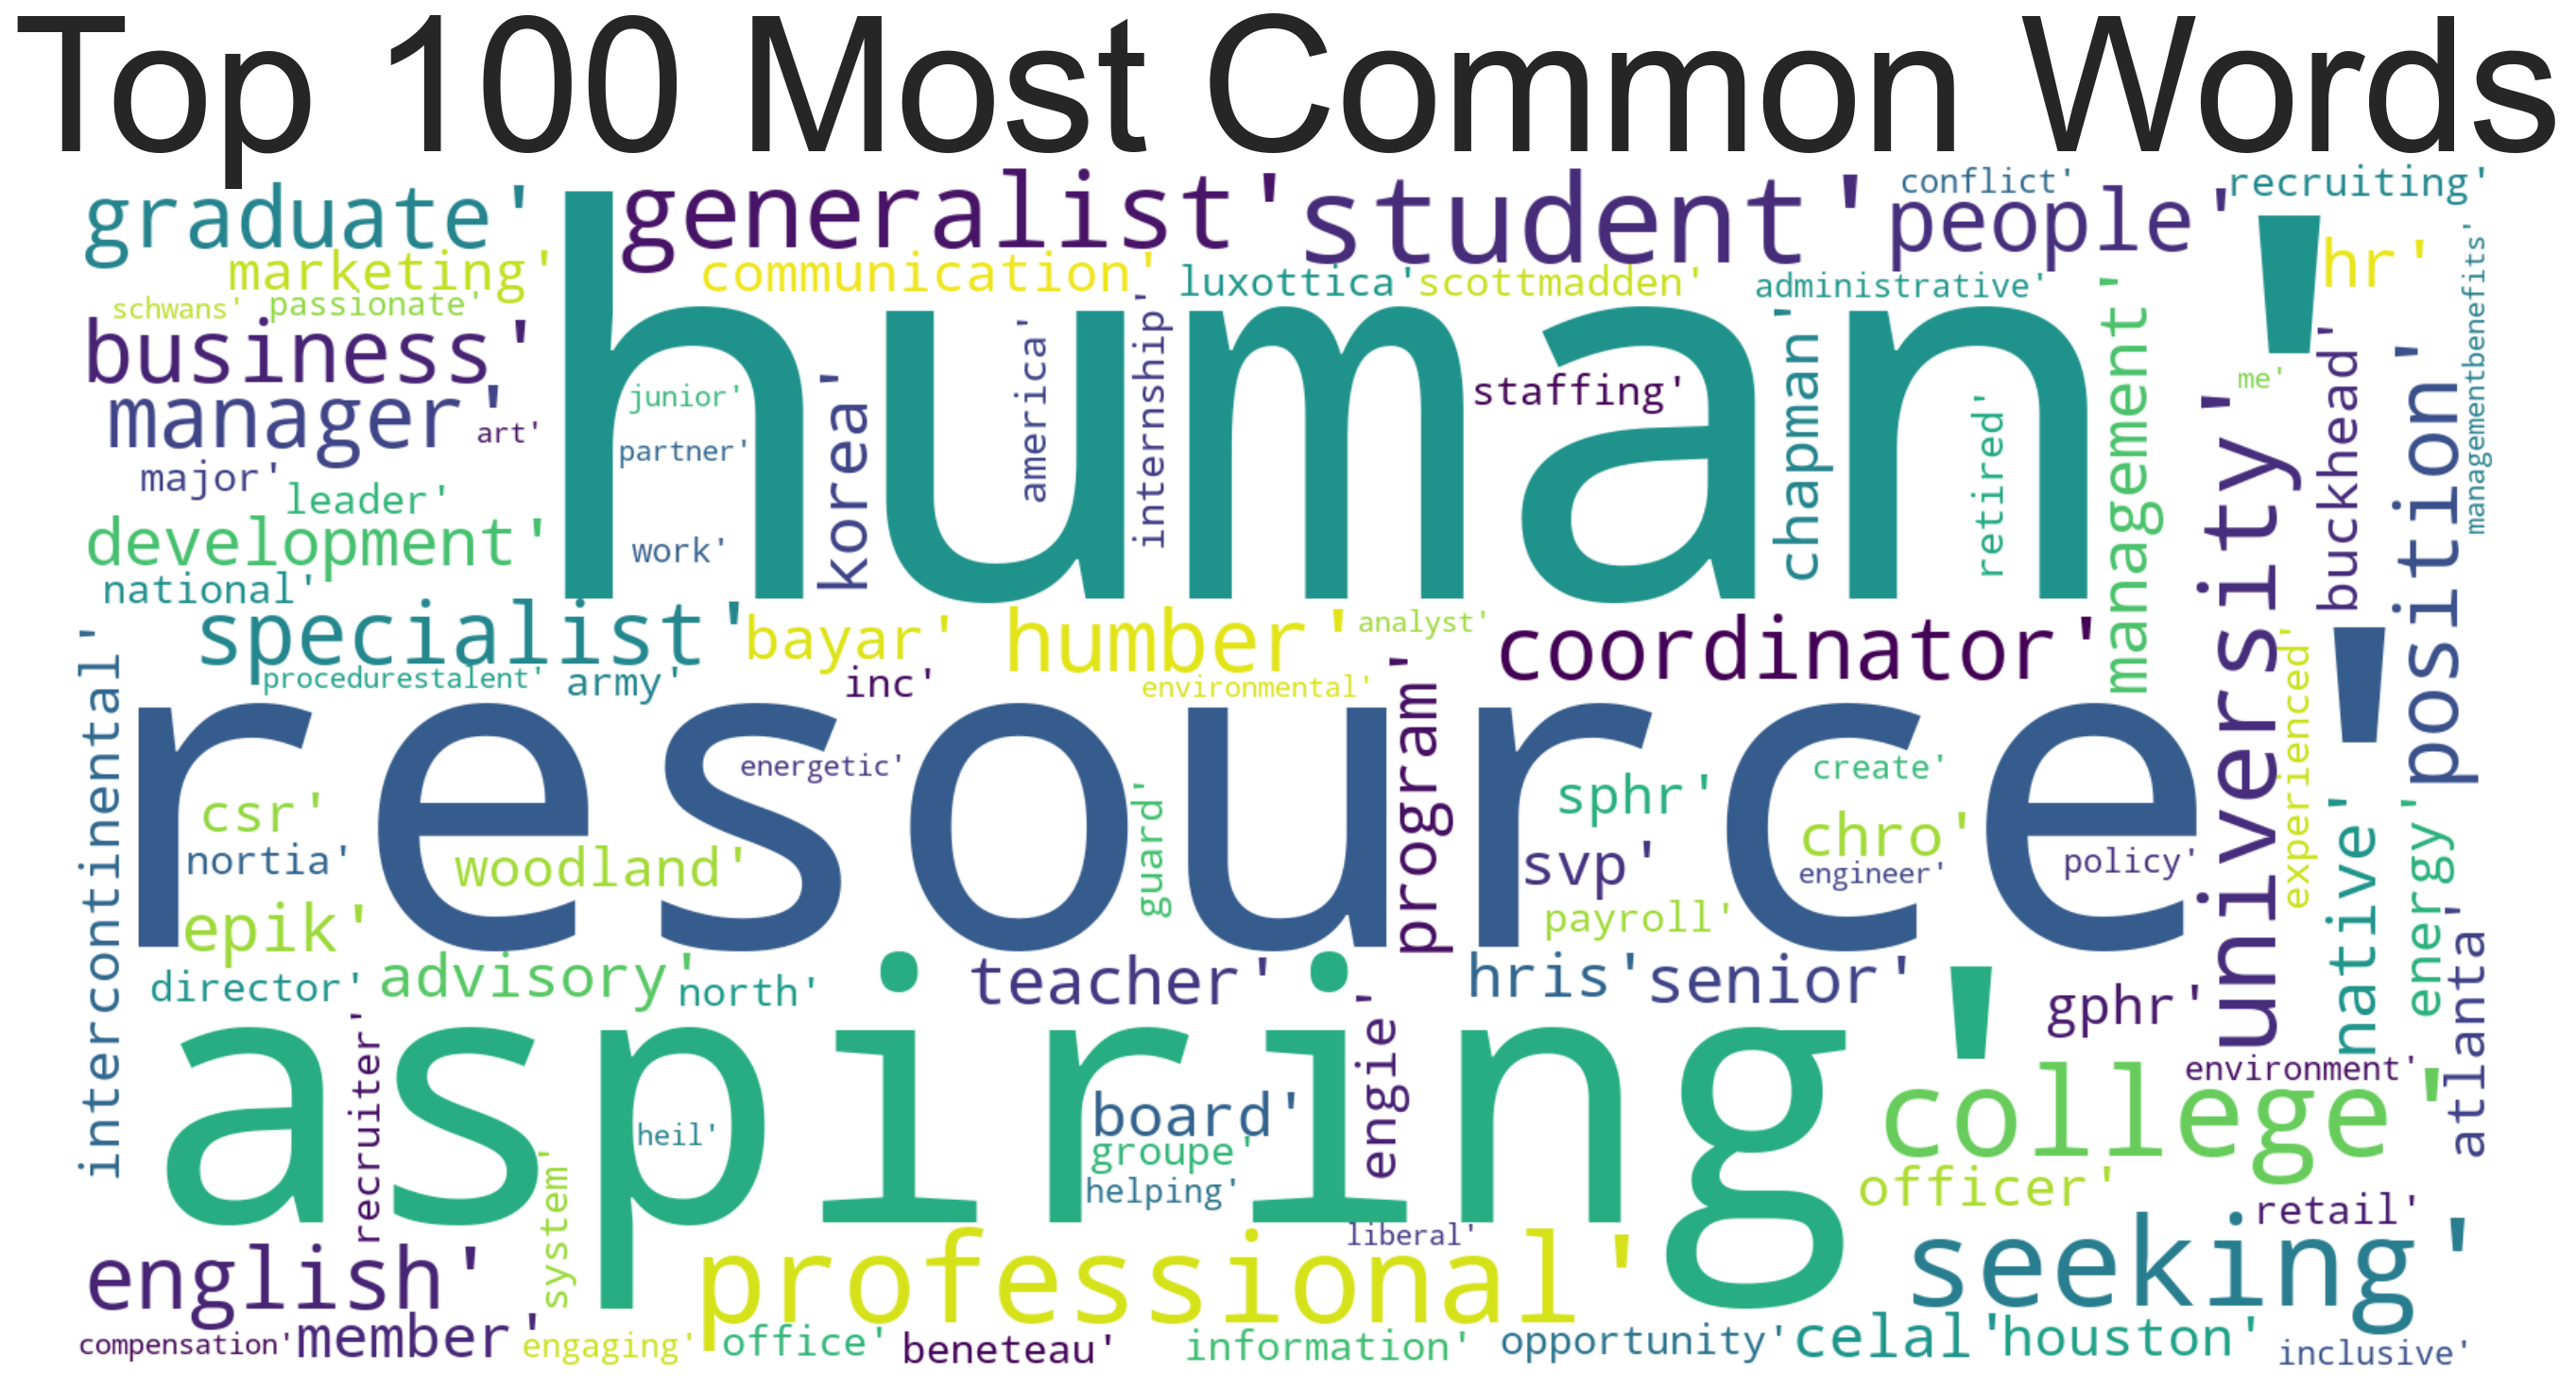

In [20]:
mostcommon = FreqDist(job_titles).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

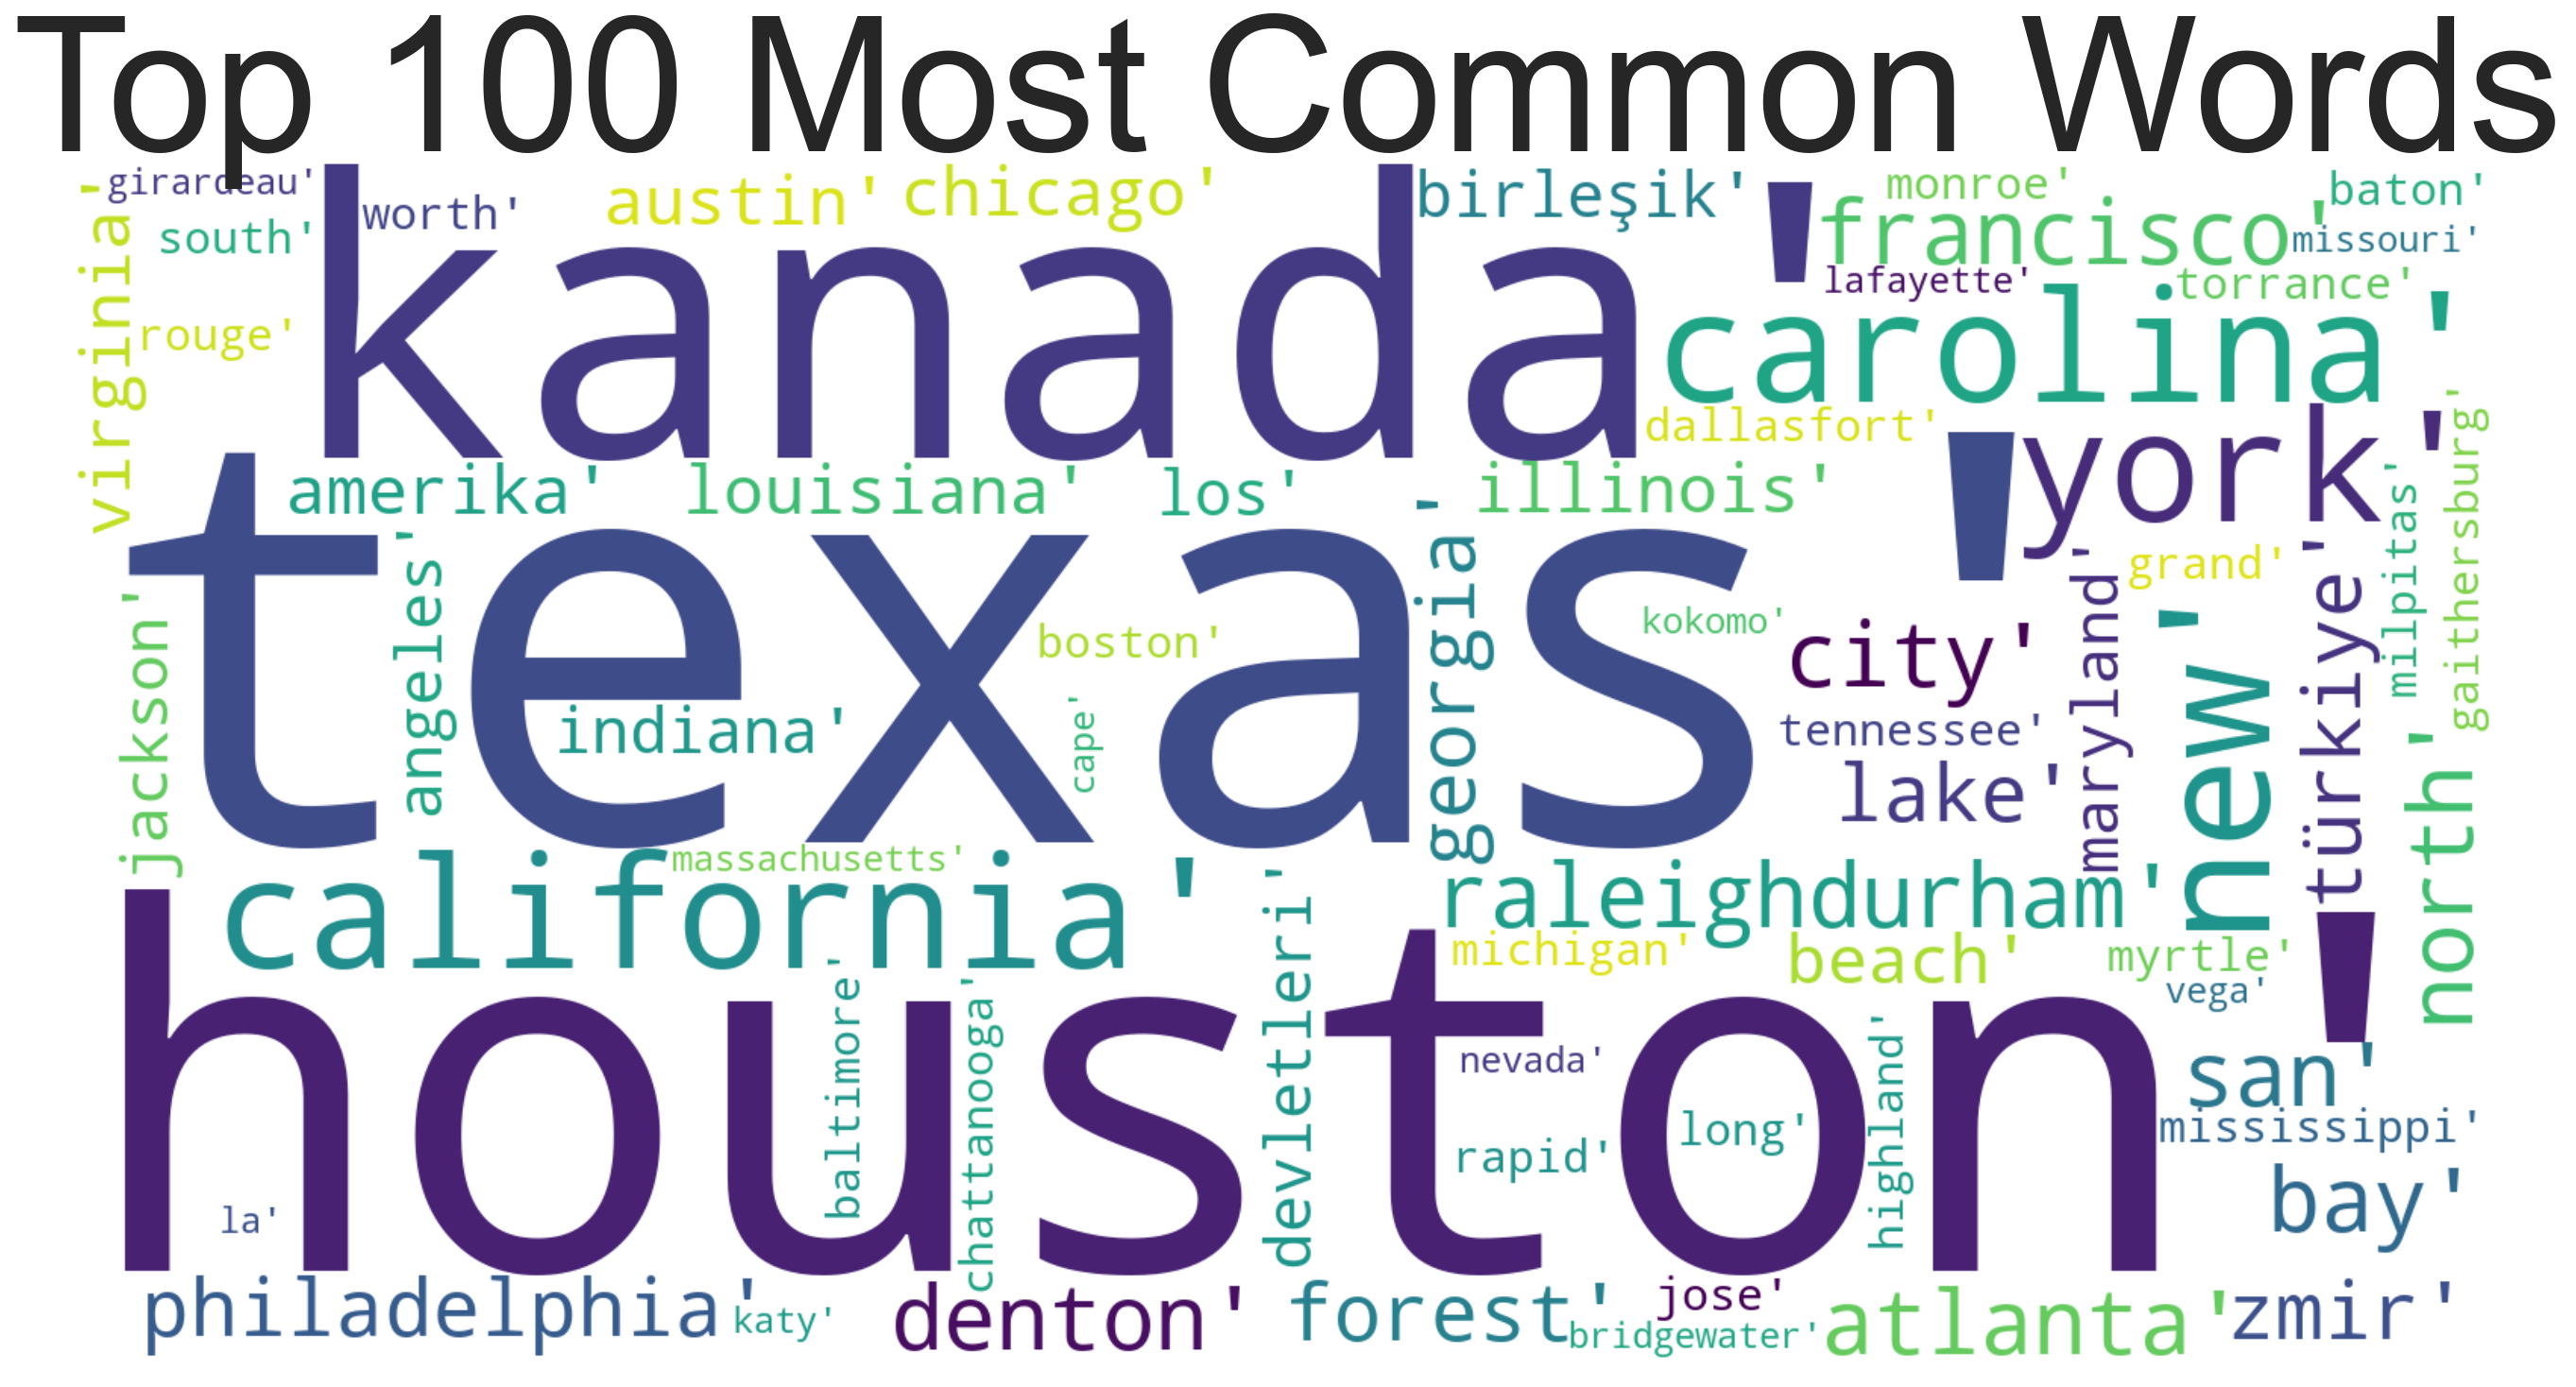

In [21]:
mostcommon = FreqDist(location).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

# Using Word Frequency Chart

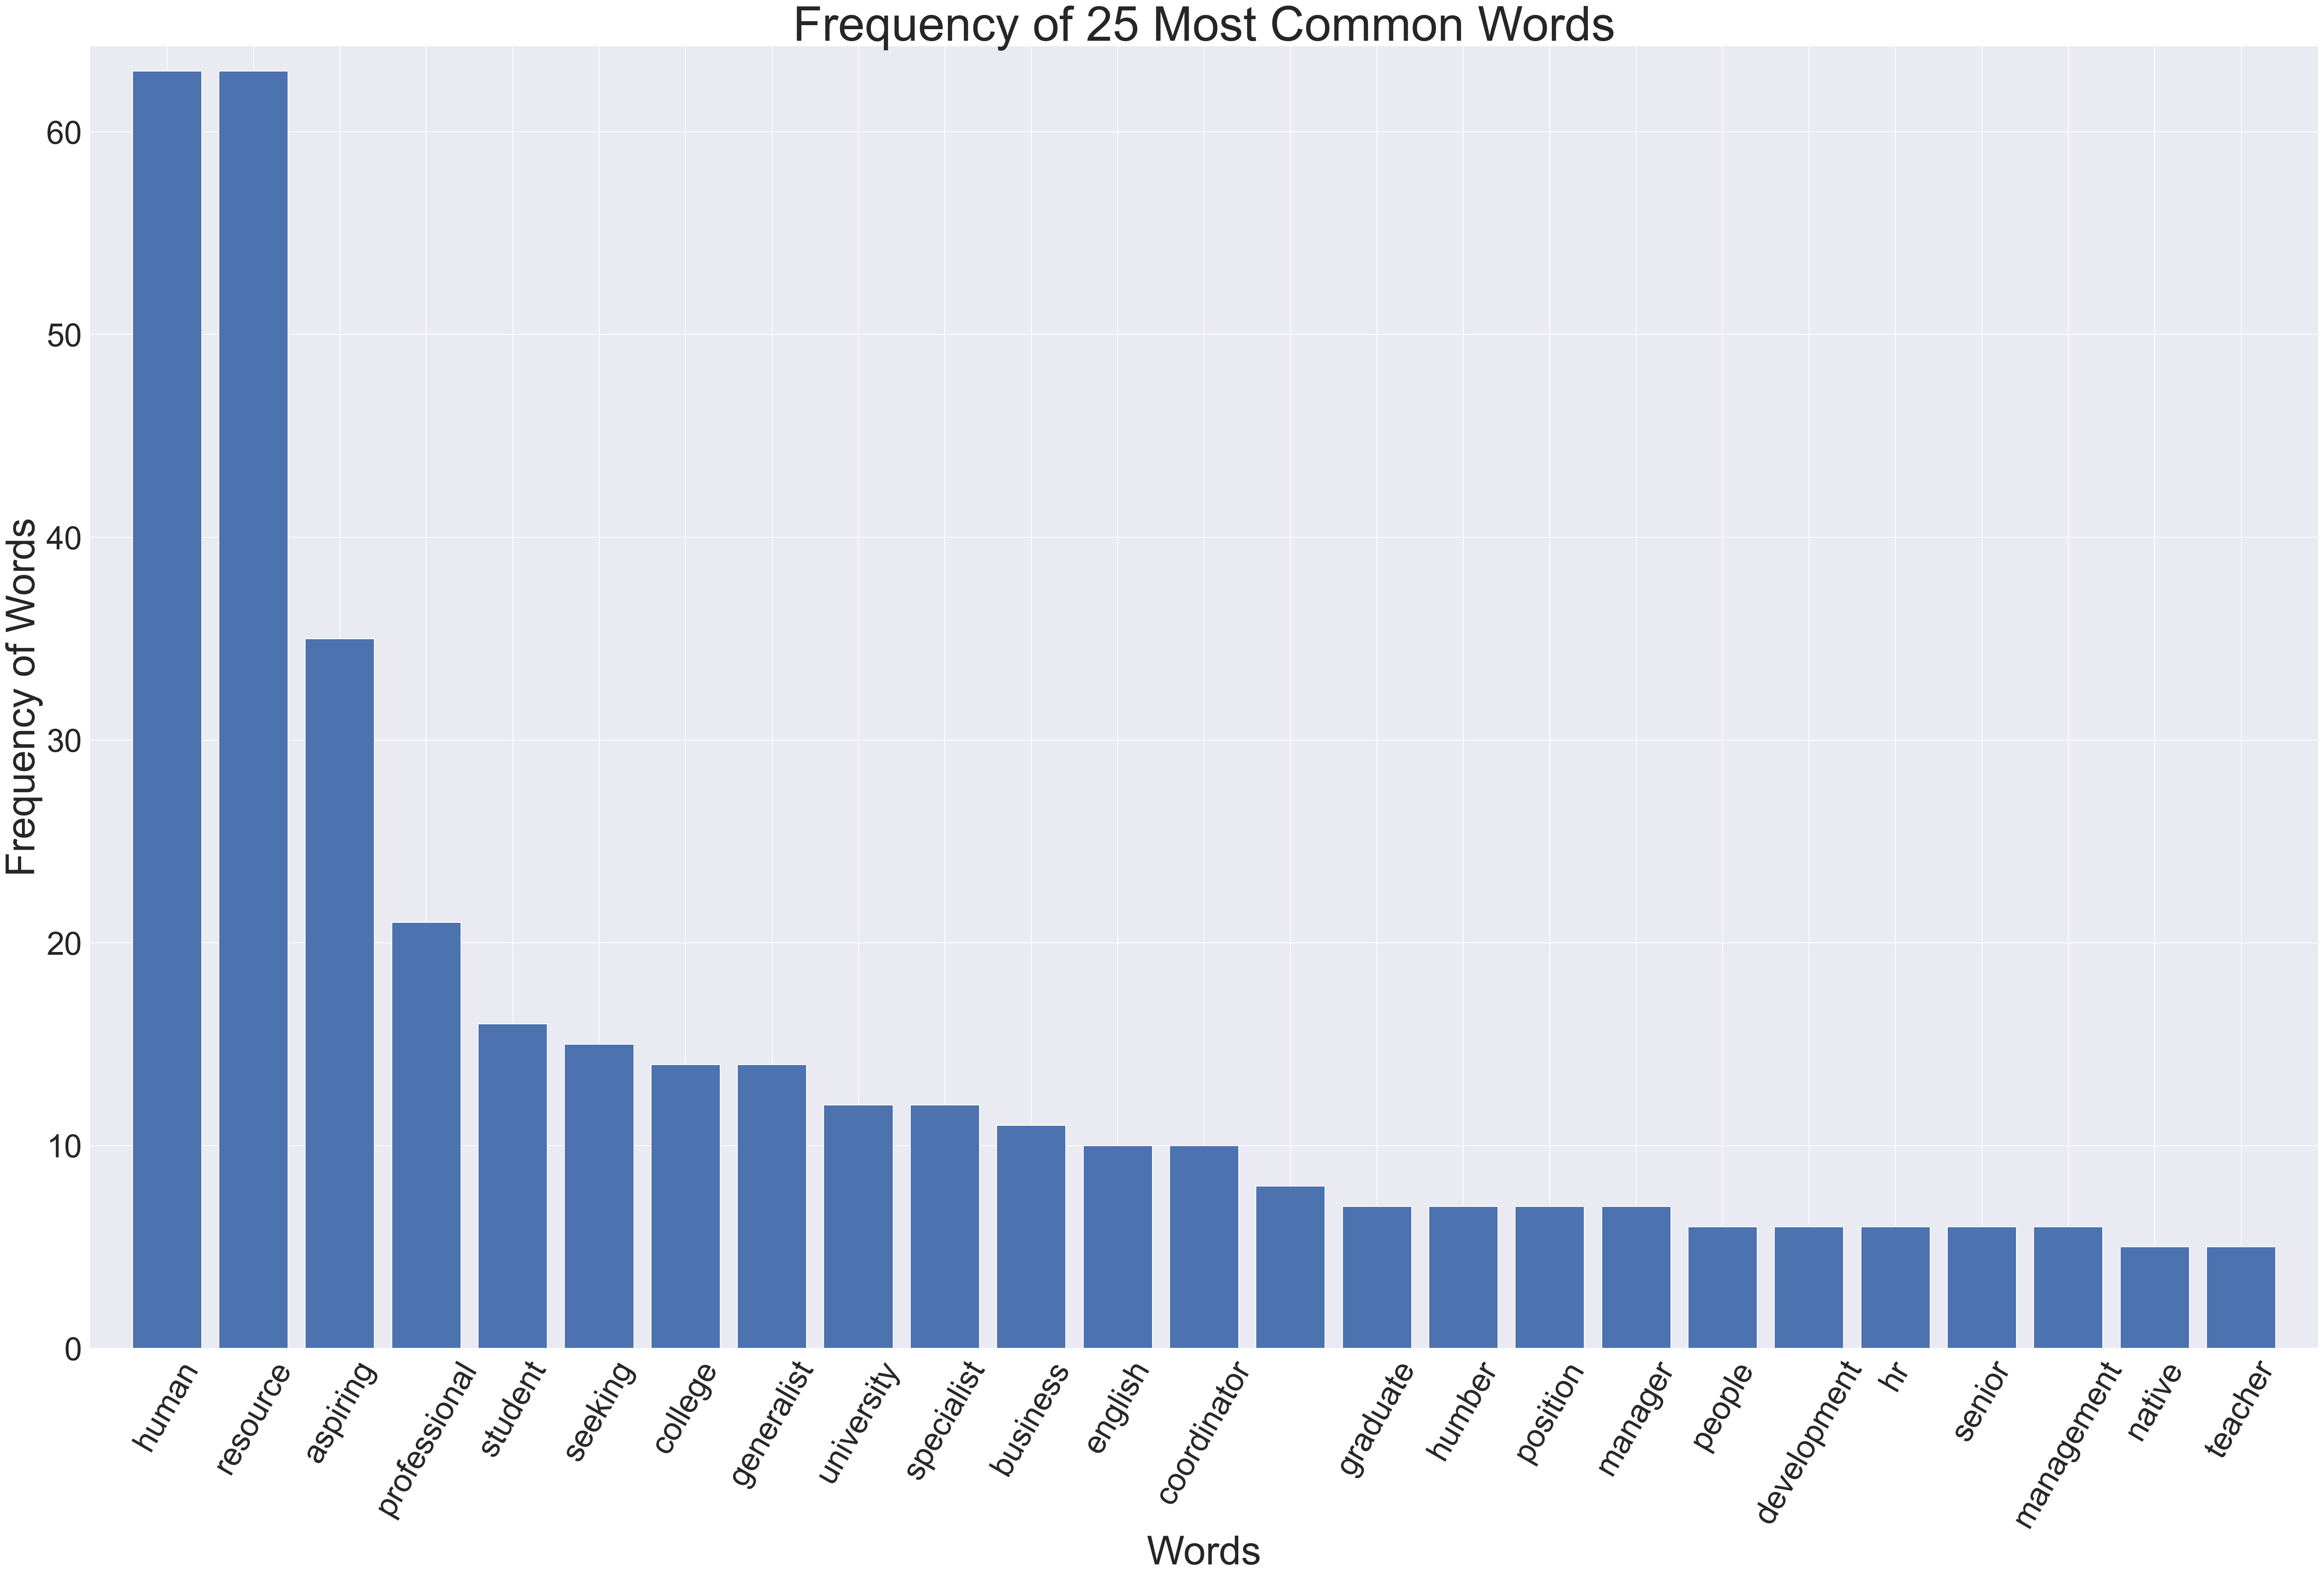

In [22]:
mostcommon_small = FreqDist(job_titles).most_common(25)
x, y = zip(*mostcommon_small)

plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

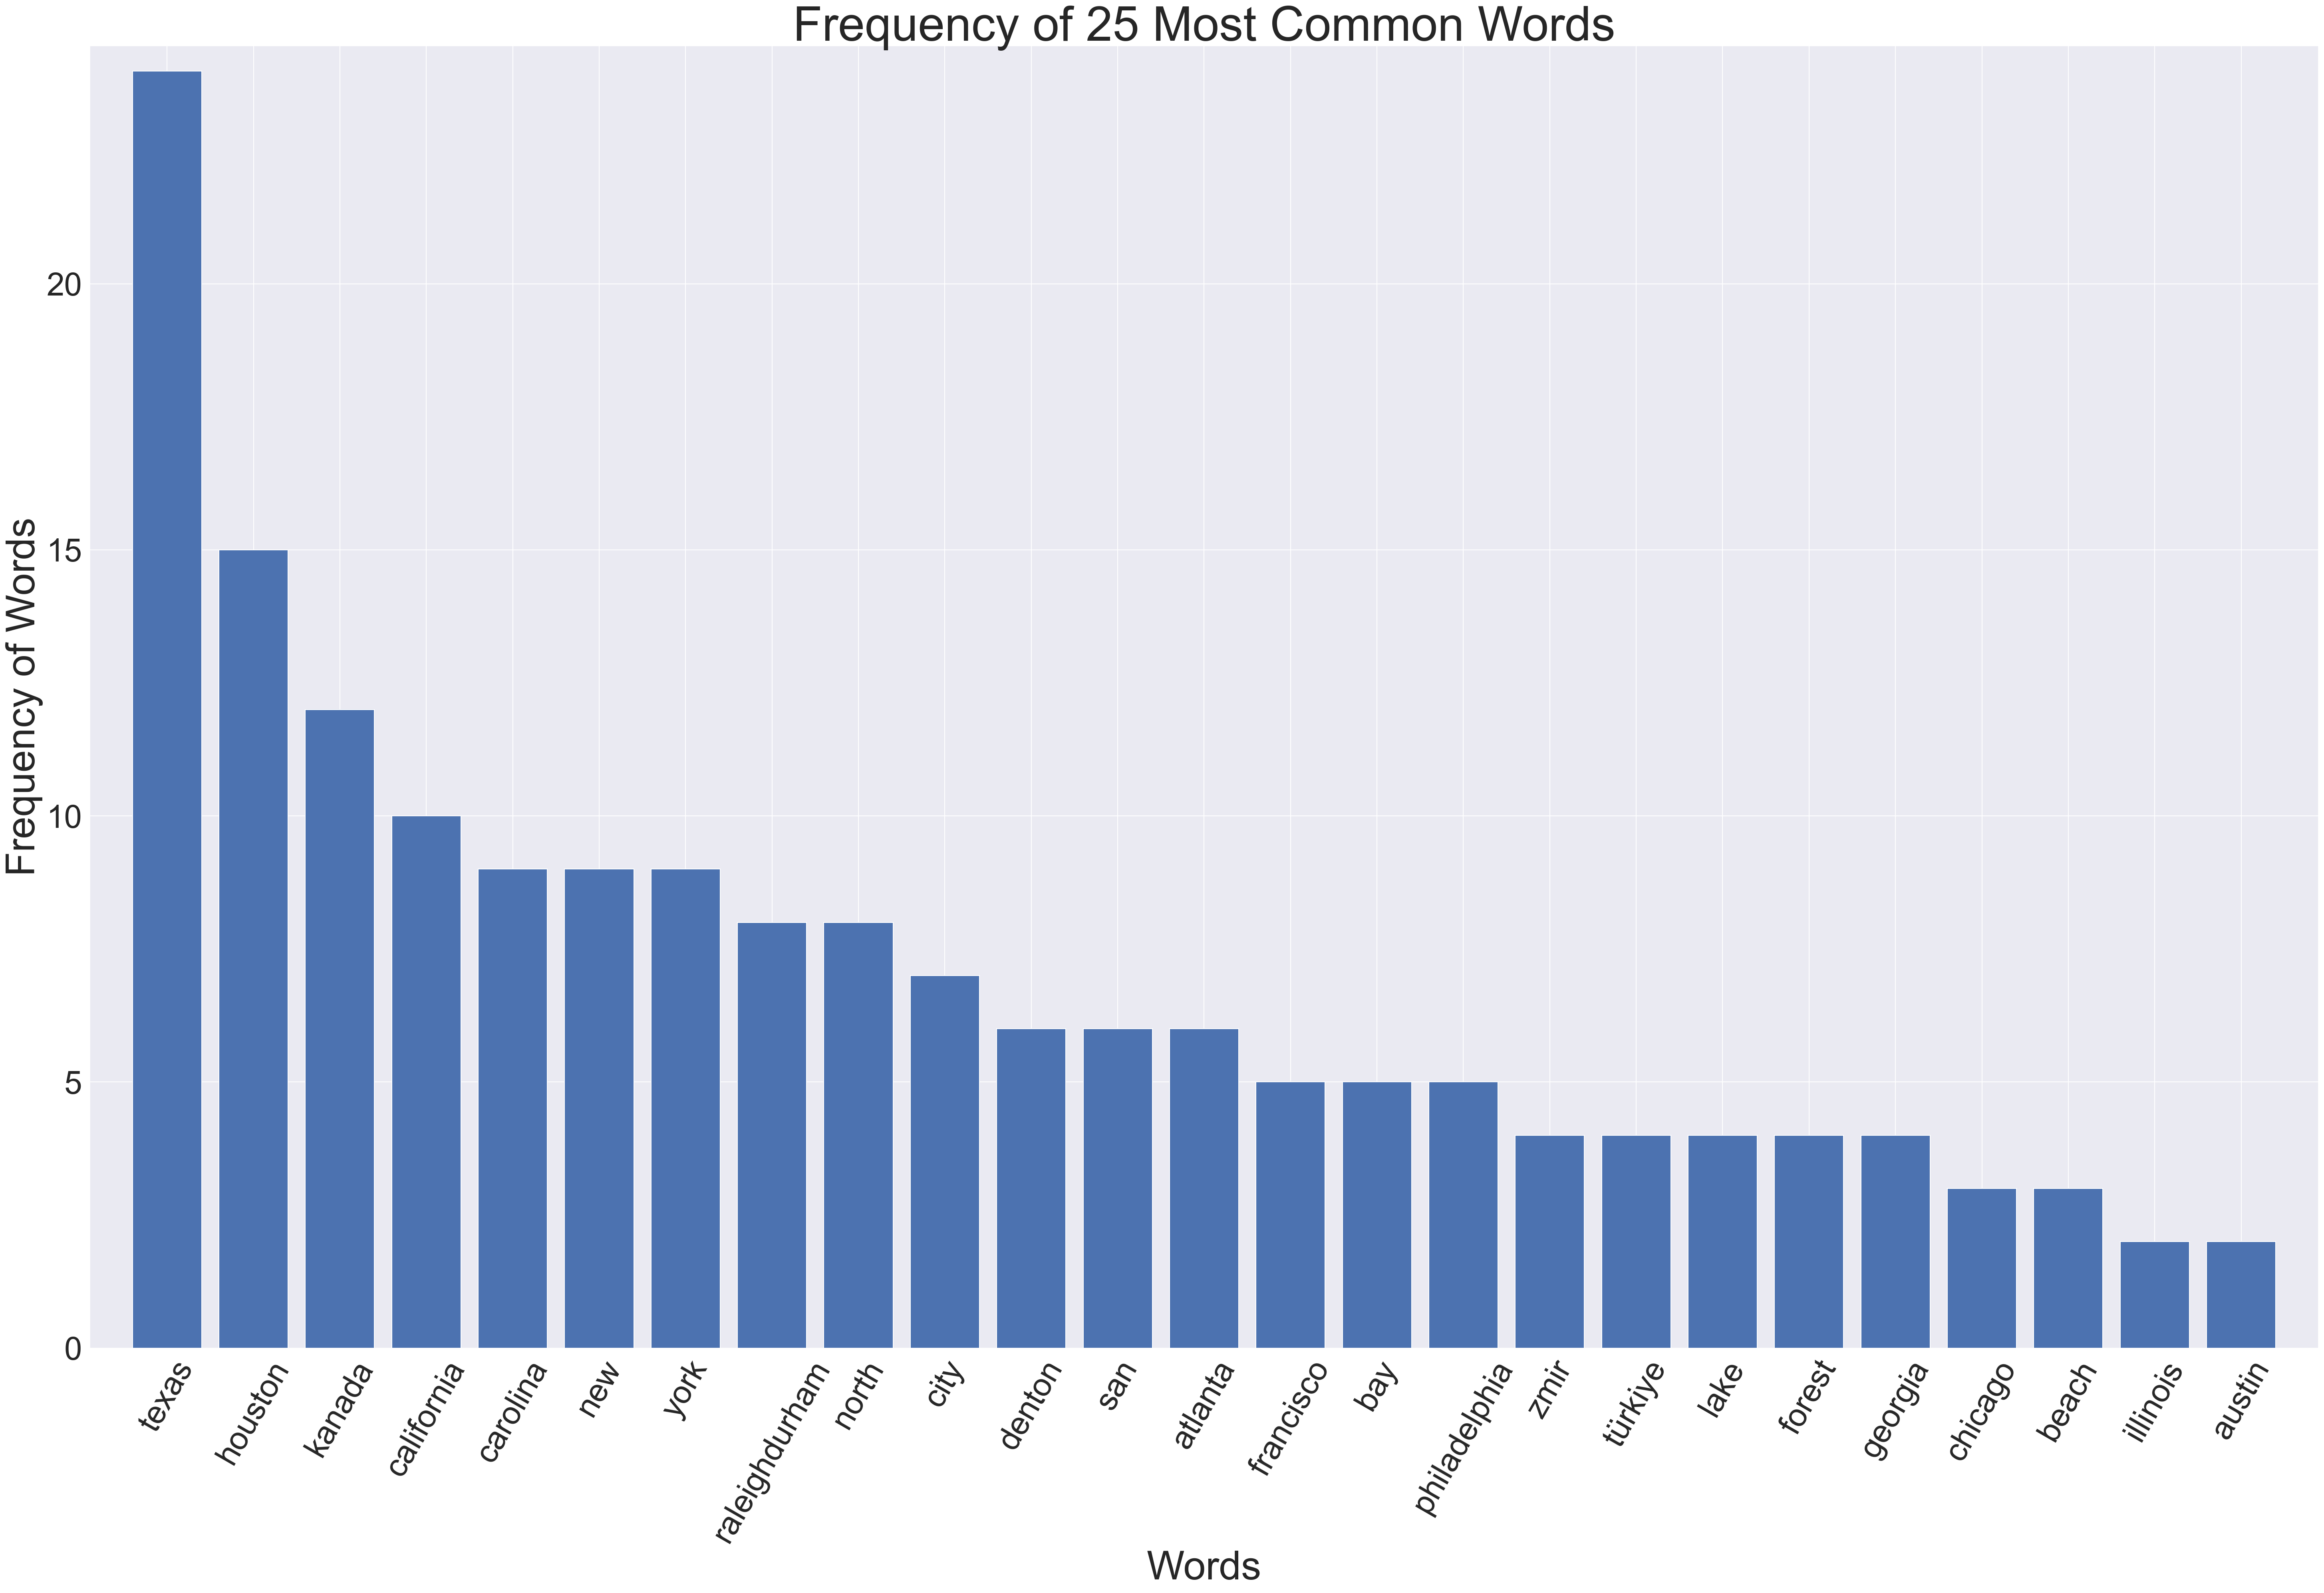

In [23]:
mostcommon_small = FreqDist(location).most_common(25)
x, y = zip(*mostcommon_small)

plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

# Using TFiDF Vectorizer with Cosine Similarity for ranking Words

In order to use tfidfVectorizer, we need to rejoin the words that we separated as the model only takes the joined words

In [24]:
# Join tokens
df['job_title_lemmatised'] = df['job_title_lemmatised'].apply(lambda x: ' '.join(x))

<ipython-input-24-9a92d58bfecf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['job_title_lemmatised'] = df['job_title_lemmatised'].apply(lambda x: ' '.join(x))


In [25]:
# Setting the vectorizer 
tvec = TfidfVectorizer(use_idf=True)

# Fitting the vectorizer on the data
df1_tvec=tvec.fit_transform(df['job_title_lemmatised'].values)

# Ranking using the first search term

In [27]:
# Define the search term
search_term = ["aspiring human resource", "seeking human resource"]

# Calculate TF-IDF on that search term
search_vec = tvec.transform(search_term)

# Calculate similarity score
# Each row is each job title
# Column is the search term
similarity_matrix = cosine_similarity(df1_tvec, search_vec)


# Get and rank the scores of the one search term only (similarity_matrix[i][0])
# If you calculate for many search terms, you have to change this (with for loop outside)
score_to_rank = [[similarity_matrix[i][0]] for i in range(len(similarity_matrix))]
df['fit'] = score_to_rank
df.head(10)


<ipython-input-27-4992b0c9268f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fit'] = score_to_rank


job_title_lemmatised  \
0   college business graduate aspiring human reso...   
1  native english teacher epik english program korea   
2               aspiring human resource professional   
3                     people development coordinator   
4       advisory board member celal bayar university   
5                 aspiring human resource specialist   
6  student humber college aspiring human resource...   
7                               hr senior specialist   
8  student humber college aspiring human resource...   
9    seeking human resource hris generalist position   

                location_lemmatised connection                    fit  
0                  [houston, texas]         85  [0.43628143157268856]  
1                          [kanada]      500+                   [0.0]  
2  [raleighdurham, north, carolina]         44    [0.759411139772506]  
3                   [denton, texas]      500+                   [0.0]  
4                   [zmir, türkiye]      500+                   [0.0]  
5                 [new, york, city]          1   [0.6956787236144735]  
6                          [kanada]         61   [0.4361722041075334]  
7             [san, francisco, bay]      500+                   [0.0]  
8                          [kanada]         61   [0.4361722041075334]  
9                    [philadelphia]      500+   [0.21871531844870723]

In [28]:
df.sort_values(by='fit', axis=0, ascending=False, inplace=True)
df.head(20)

<ipython-input-28-bc26bb1c0dda>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by='fit', axis=0, ascending=False, inplace=True)


job_title_lemmatised  \
96               aspiring human resource professional   
45               aspiring human resource professional   
2                aspiring human resource professional   
16               aspiring human resource professional   
57               aspiring human resource professional   
20               aspiring human resource professional   
32               aspiring human resource professional   
48                 aspiring human resource specialist   
5                  aspiring human resource specialist   
35                 aspiring human resource specialist   
59                 aspiring human resource specialist   
23                 aspiring human resource specialist   
72  aspiring human resource manager seeking intern...   
73                        human resource professional   
30   college business graduate aspiring human reso...   
18   college business graduate aspiring human reso...   
56   college business graduate aspiring human reso...   
0    college business graduate aspiring human reso...   
43   college business graduate aspiring human reso...   
14   college business graduate aspiring human reso...   

                 location_lemmatised connection                    fit  
96                 [kokomo, indiana]         71    [0.759411139772506]  
45  [raleighdurham, north, carolina]         44    [0.759411139772506]  
2   [raleighdurham, north, carolina]         44    [0.759411139772506]  
16  [raleighdurham, north, carolina]         44    [0.759411139772506]  
57  [raleighdurham, north, carolina]         44    [0.759411139772506]  
20  [raleighdurham, north, carolina]         44    [0.759411139772506]  
32  [raleighdurham, north, carolina]         44    [0.759411139772506]  
48                 [new, york, city]          1   [0.6956787236144735]  
5                  [new, york, city]          1   [0.6956787236144735]  
35                 [new, york, city]          1   [0.6956787236144735]  
59                 [new, york, city]          1   [0.6956787236144735]  
23                 [new, york, city]          1   [0.6956787236144735]  
72                  [houston, texas]          7    [0.576793982756681]  
73                          [boston]         16  [0.46506185855602294]  
30                  [houston, texas]         85  [0.43628143157268856]  
18                  [houston, texas]         85  [0.43628143157268856]  
56                  [houston, texas]         85  [0.43628143157268856]  
0                   [houston, texas]         85  [0.43628143157268856]  
43                  [houston, texas]         85  [0.43628143157268856]  
14                  [houston, texas]         85  [0.43628143157268856]

# Ranking Using second search term

In [29]:
score_to_rank = [[similarity_matrix[i][1]] for i in range(len(similarity_matrix))]
df['fit'] = score_to_rank
df.head(10)

<ipython-input-29-4ed80f621812>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fit'] = score_to_rank


job_title_lemmatised               location_lemmatised  \
96  aspiring human resource professional                 [kokomo, indiana]   
45  aspiring human resource professional  [raleighdurham, north, carolina]   
2   aspiring human resource professional  [raleighdurham, north, carolina]   
16  aspiring human resource professional  [raleighdurham, north, carolina]   
57  aspiring human resource professional  [raleighdurham, north, carolina]   
20  aspiring human resource professional  [raleighdurham, north, carolina]   
32  aspiring human resource professional  [raleighdurham, north, carolina]   
48    aspiring human resource specialist                 [new, york, city]   
5     aspiring human resource specialist                 [new, york, city]   
35    aspiring human resource specialist                 [new, york, city]   

   connection                    fit  
96         71  [0.18884451428643137]  
45         44                  [0.0]  
2          44   [0.3287112800494022]  
16         44                  [0.0]  
57         44                  [0.0]  
20         44   [0.3011246895995651]  
32         44   [0.1887972351539466]  
48          1                  [0.0]  
5           1   [0.1887972351539466]  
35          1   [0.5052909934939769]

In [30]:
df.sort_values(by='fit', axis=0, ascending=False, inplace=True)
df.head(20)

<ipython-input-30-bc26bb1c0dda>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by='fit', axis=0, ascending=False, inplace=True)


job_title_lemmatised  \
22        advisory board member celal bayar university   
28   aspiring human resource management student see...   
36   student humber college aspiring human resource...   
7                                 hr senior specialist   
64   human resource coordinator intercontinental bu...   
100                  human resource generalist loparex   
92   admission representative community medical cen...   
35                  aspiring human resource specialist   
26   aspiring human resource management student see...   
6    student humber college aspiring human resource...   
10                          student chapman university   
21                      people development coordinator   
33                      people development coordinator   
97                                             student   
9      seeking human resource hris generalist position   
68   director human resource north america groupe b...   
13    college business graduate aspiring human reso...   
56    college business graduate aspiring human reso...   
31   native english teacher epik english program korea   
2                 aspiring human resource professional   

                  location_lemmatised connection                    fit  
22                    [zmir, türkiye]      500+    [0.7096775137195293]  
28                   [houston, texas]      500+    [0.6649332283463288]  
36                           [kanada]         61   [0.6649332283463288]  
7               [san, francisco, bay]      500+    [0.6205887371111665]  
64                 [atlanta, georgia]      500+    [0.5052909934939769]  
100  [raleighdurham, north, carolina]      500+    [0.5052909934939769]  
92          [long, beach, california]          9   [0.5052909934939769]  
35                  [new, york, city]          1   [0.5052909934939769]  
26                   [houston, texas]      500+    [0.4762057515244608]  
6                            [kanada]         61   [0.4762057515244608]  
10         [lake, forest, california]          2  [0.38638455666110155]  
21                    [denton, texas]      500+   [0.36505201899506234]  
33                    [denton, texas]      500+     [0.354521566843722]  
97                   [houston, texas]          4  [0.33706432472685155]  
9                      [philadelphia]      500+    [0.3287112800494022]  
68           [grand, rapid, michigan]      500+    [0.3287112800494022]  
13                   [houston, texas]         85   [0.3287112800494022]  
56                   [houston, texas]         85   [0.3287112800494022]  
31                           [kanada]      500+    [0.3287112800494022]  
2    [raleighdurham, north, carolina]         44   [0.3287112800494022]